In [18]:
import pandas as pd
import numpy as np
import openpyxl

import string
import nltk
from nltk.corpus import wordnet
import itertools
from stempel import StempelStemmer
import morfeusz2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
stopwords = nltk.corpus.stopwords.words('polish.txt')
stopwords

['a',
 'aby',
 'ach',
 'acz',
 'aczkolwiek',
 'aj',
 'albo',
 'ale',
 'alez',
 'ależ',
 'ani',
 'az',
 'aż',
 'bardziej',
 'bardzo',
 'beda',
 'bedzie',
 'bez',
 'deda',
 'będą',
 'bede',
 'będę',
 'będzie',
 'bo',
 'bowiem',
 'by',
 'byc',
 'być',
 'byl',
 'byla',
 'byli',
 'bylo',
 'byly',
 'był',
 'była',
 'było',
 'były',
 'bynajmniej',
 'cala',
 'cali',
 'caly',
 'cała',
 'cały',
 'ci',
 'cie',
 'ciebie',
 'cię',
 'co',
 'cokolwiek',
 'cos',
 'coś',
 'czasami',
 'czasem',
 'czemu',
 'czy',
 'czyli',
 'daleko',
 'dla',
 'dlaczego',
 'dlatego',
 'do',
 'dobrze',
 'dokad',
 'dokąd',
 'dosc',
 'dość',
 'duzo',
 'dużo',
 'dwa',
 'dwaj',
 'dwie',
 'dwoje',
 'dzis',
 'dzisiaj',
 'dziś',
 'gdy',
 'gdyby',
 'gdyz',
 'gdyż',
 'gdzie',
 'gdziekolwiek',
 'gdzies',
 'gdzieś',
 'go',
 'i',
 'ich',
 'ile',
 'im',
 'inna',
 'inne',
 'inny',
 'innych',
 'iz',
 'iż',
 'ja',
 'jak',
 'jakas',
 'jakaś',
 'jakby',
 'jaki',
 'jakichs',
 'jakichś',
 'jakie',
 'jakis',
 'jakiś',
 'jakiz',
 'jakiż',
 'jak

In [8]:
# Remove Punctuation
class RemovePunctuationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column    
    
    def fit(self, X, y = None):
        return self    
    
    def transform(self, X, y = None):
        def remove_punctuation(text):
            cleaned = ''.join([word for word in text if word not in string.punctuation])
            return cleaned
        
        X_transformed = X.copy()
        X_transformed[self.text_column] = X_transformed[self.text_column].apply(lambda x: remove_punctuation(x))
        
        return X_transformed

# Tokenizer
class TokenizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column    
    
    def fit(self, X, y = None):
        return self    
    
    def transform(self, X, y = None):
        def tokenizer(text):
            # Usunięcie wielkich liter
            clean_text = text.lower()
            # Tokenizacja
            tokenized_text = nltk.word_tokenize(clean_text)
            return tokenized_text
        
        X_transformed = X.copy()
        X_transformed[self.text_column] = X_transformed[self.text_column].apply(lambda x: tokenizer(x))
        
        return X_transformed

# Remove Stopwords
class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column    
    
    def fit(self, X, y = None):
        return self    
    
    def transform(self, X, y = None):
        def remove_stopwords(text):
            without_stopwords = [word for word in text if word not in stopwords]
            return without_stopwords
        
        X_transformed = X.copy()
        X_transformed[self.text_column] = X_transformed[self.text_column].apply(lambda x: remove_stopwords(x))
        
        return X_transformed

# Stemming
class StemmingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column    
    
    def fit(self, X, y = None):
        return self    
    
    def transform(self, X, y = None):
        stemmer = StempelStemmer.default()
        def stemming(text):
            stemmed_words = [stemmer.stem(word) for word in text]
            return stemmed_words
        
        X_transformed = X.copy()
        X_transformed[self.text_column] = X_transformed[self.text_column].apply(lambda x: stemming(x))
        
        return X_transformed

In [9]:
df_raw = pd.read_csv('C:/Users/Kamil/Jupyter Notebook/Projekt piosenki SDA/all_lyrics_clean.csv',
                 encoding='ISO-8859-1', header=None, names=['Lyrics'])

nlp_pipeline = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='Lyrics')), 
    ('tokenizer', TokenizerTransformer(text_column='Lyrics')),
    ('remove_stopwords', RemoveStopwordsTransformer(text_column='Lyrics')),
])
nlp_pipeline.fit_transform(df_raw)

,Lyrics
0,"[wiatr, slady, zawieje, dobre, luzle, jesienia..."
1,"[czarne, chmury, nanamiiskrza, blyskawicami, p..."
2,"[poszlismy, raz, spacer, trzymalas, reke, gral..."
3,"[wstep, adurmol, mol, hmol, dduredur, sunshine..."
4,"[ireii, wiatr, zaplatal, twa, sukienke, pewnie..."
...,...
9649,"[ludzie, buduja, fabryki, buduja, mcdonaldy, z..."
9650,"[kolejny, poranek, kolejny, smutny, dzien, wie..."
9651,"[zywiol, glupca, rozmowa, zna, odpowiedz, skom..."
9652,"[zostawiaj, prosze, lezana, podlodze, slydze, ..."


In [10]:
# Get values from the list
class Return_String_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column
        
    
    def fit(self, X, y = None):
        return self
    
    
    def transform(self, X, y=None):
        
        X_transformed = X.copy()
        X_transformed[self.text_column] = X_transformed[self.text_column].apply(lambda x: ' '.join(x))
        X_transformed = pd.Series(X_transformed[self.text_column])
        
        return X_transformed

In [11]:
nlp_pipeline = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='Lyrics')), 
    ('tokenizer', TokenizerTransformer(text_column='Lyrics')),
    ('remove_stopwords', RemoveStopwordsTransformer(text_column='Lyrics')), 
    ('return_string', Return_String_Transformer(text_column='Lyrics'))
])

nlp_pipeline.fit_transform(df_raw)

0       wiatr slady zawieje dobre luzle jesienia pojde...
1       czarne chmury nanamiiskrza blyskawicami pora s...
2       poszlismy raz spacer trzymalas reke gralem git...
3       wstep adurmol mol hmol dduredur sunshine sunsh...
4       ireii wiatr zaplatal twa sukienke pewnie zazdr...
                              ...                        
9649    ludzie buduja fabryki buduja mcdonaldy zatruwa...
9650    kolejny poranek kolejny smutny dzien wiem robi...
9651    zywiol glupca rozmowa zna odpowiedz skomplikow...
9652    zostawiaj prosze lezana podlodze slydze kroki ...
9653    ucieknie domu latem rok szosie zlapie autostop...
Name: Lyrics, Length: 9654, dtype: object

In [12]:
nlp_pipeline = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='Lyrics')), 
    ('tokenizer', TokenizerTransformer(text_column='Lyrics')),
    ('remove_stopwords', RemoveStopwordsTransformer(text_column='Lyrics')), 
    ('return_string', Return_String_Transformer(text_column='Lyrics')),
    ('count_vectorizer', CountVectorizer(min_df=0.01, max_df=0.33, ngram_range=(1, 3)))
])

X_train_transformed = nlp_pipeline.fit_transform(df_raw)
X_train_transformed

<9654x724 sparse matrix of type '<class 'numpy.int64'>'
	with 173651 stored elements in Compressed Sparse Row format>

In [13]:
X_train_transformed.toarray()[:2, :]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
nlp_pipeline['count_vectorizer'].vocabulary_

{'wiatr': 616,
 'dobre': 119,
 'pojde': 398,
 'zlota': 690,
 'rzeka': 459,
 'lsni': 243,
 'las': 229,
 'spiew': 507,
 'niebo': 329,
 'zna': 698,
 'snieg': 501,
 'jutro': 192,
 'swiat': 540,
 'masz': 259,
 'zapomniec': 675,
 'czarne': 76,
 'chmury': 53,
 'pora': 402,
 'milosc': 280,
 'czego': 80,
 'sto': 526,
 'dosyc': 125,
 'twoich': 590,
 'niebie': 328,
 'kochanie': 206,
 'cicho': 67,
 'chce': 44,
 'drzwi': 136,
 'moich': 289,
 'myslec': 311,
 'wcale': 609,
 'bylas': 30,
 'pamiec': 360,
 'czym': 93,
 'widziec': 623,
 'wiecej': 626,
 'raz': 441,
 'reke': 448,
 'ciagle': 64,
 'jestes': 190,
 'sa': 461,
 'bylem': 32,
 'slowa': 485,
 'lato': 231,
 'wokol': 651,
 'czekam': 84,
 'usmiech': 600,
 'pozwol': 413,
 'wlosy': 646,
 'twe': 587,
 'miloscia': 282,
 'gore': 166,
 'rece': 445,
 'ruch': 455,
 'daj': 96,
 'chcesz': 46,
 'zmienic': 697,
 'znasz': 706,
 'twa': 583,
 'pewnie': 375,
 'wierze': 639,
 'trwa': 577,
 'czas': 78,
 'drogi': 130,
 'serce': 470,
 'wola': 652,
 'placze': 393,
 'la':

In [15]:
nlp_pipeline = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='Lyrics')), 
    ('tokenizer', TokenizerTransformer(text_column='Lyrics')),
    ('remove_stopwords', RemoveStopwordsTransformer(text_column='Lyrics')), 
    ('return_string', Return_String_Transformer(text_column='Lyrics')),
    ('tfidf_vectorizer', TfidfVectorizer(min_df=0.01, max_df=0.33, ngram_range=(1, 3), use_idf=True))
])

X_train_transformed = nlp_pipeline.fit_transform(df_raw)
X_train_transformed

<9654x724 sparse matrix of type '<class 'numpy.float64'>'
	with 173651 stored elements in Compressed Sparse Row format>

In [16]:
X_train_transformed.toarray()[:100]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11476337,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

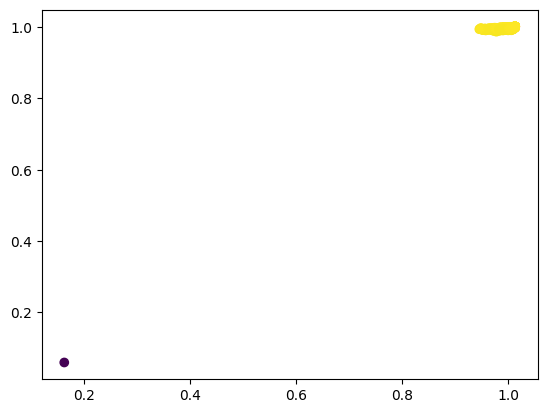

In [30]:
nlp_pipeline_clustering = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='Lyrics')), 
    ('tokenizer', TokenizerTransformer(text_column='Lyrics')),
    ('remove_stopwords', RemoveStopwordsTransformer(text_column='Lyrics')), 
    ('return_string', Return_String_Transformer(text_column='Lyrics')),
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('clustering_1', KMeans(n_clusters=4, random_state=0))
])

nlp_pipeline_clustering.get_params().keys()
tsne_features = nlp_pipeline_clustering.fit_transform(df_raw)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
plt.scatter(xs, ys, c=ys)
plt.show()

C:\Users\Kamil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


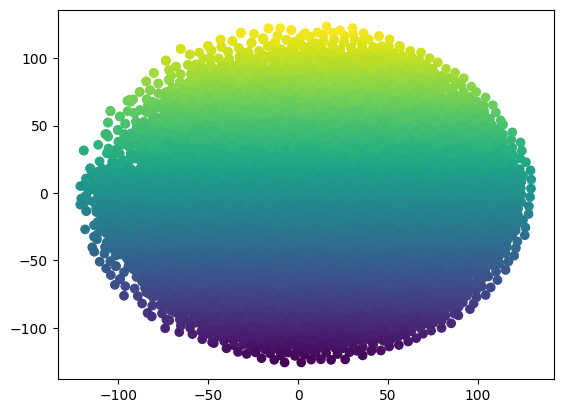

In [19]:
nlp_pipeline_clustering = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='Lyrics')), 
    ('tokenizer', TokenizerTransformer(text_column='Lyrics')),
    ('remove_stopwords', RemoveStopwordsTransformer(text_column='Lyrics')), 
    ('return_string', Return_String_Transformer(text_column='Lyrics')),
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('clustering', TSNE(learning_rate=300))
])

nlp_pipeline_clustering.get_params().keys()
tsne_features = nlp_pipeline_clustering.fit_transform(df_raw)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
plt.scatter(xs, ys, c=ys)
plt.show()

C:\Users\Kamil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


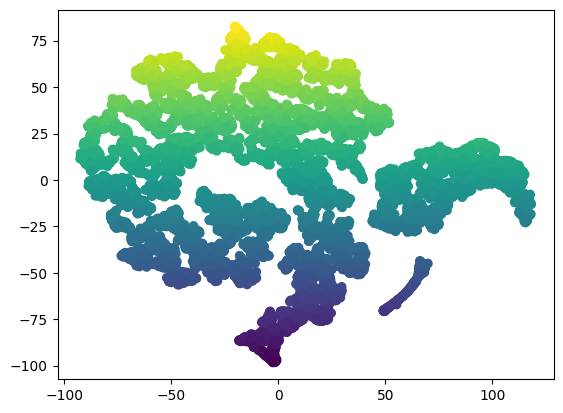

In [28]:
nlp_pipeline_clustering = Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='Lyrics')), 
    ('tokenizer', TokenizerTransformer(text_column='Lyrics')),
    ('remove_stopwords', RemoveStopwordsTransformer(text_column='Lyrics')), 
    ('return_string', Return_String_Transformer(text_column='Lyrics')),
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('clustering_1', KMeans(n_clusters=3, random_state=0)),
    ('clustering_2', TSNE(learning_rate=300))
])

nlp_pipeline_clustering.get_params().keys()
tsne_features = nlp_pipeline_clustering.fit_transform(df_raw)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
plt.scatter(xs, ys, c=ys)
plt.show()